In [1]:
!pip install fredapi

import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from fredapi import Fred
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA

# Category 5: Linear Discriminant Analysis.

## Data Collection

In [2]:
# Set your FRED API key
fred_api_key = '3d3a1eeebbb593d2d9694a8b9c70b18d'
fred = Fred(api_key=fred_api_key)

# Define the tickers and FRED series
tickers = ['^GSPC', '^NDX', '^VIX', '^TNX', 'GC=F', 'BTC-USD']
fred_series = {'FFR': 'FEDFUNDS', 'Baa_Yield': 'BAA', 'Aaa_Yield': 'AAA'}

# Define the date range
start_date = '2010-01-01'
end_date = '2025-01-01'

In [3]:
# Function to fetch data from Yahoo Finance
def fetch_yahoo_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)['Close']
    return data

# Function to fetch data from FRED
def fetch_fred_data(series_dict, start, end):
    data = pd.DataFrame()
    for name, series_id in series_dict.items():
        series_data = fred.get_series(series_id, start, end)
        data[name] = series_data
    return data

In [4]:
# Fetch market-based data
market_data = fetch_yahoo_data(tickers, start_date, end_date)
market_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed


Ticker,BTC-USD,GC=F,^GSPC,^NDX,^TNX,^VIX
Date,,,,,,
2010-01-04,NaN,1117.699951,1132.989990,1886.699951,3.841,20.040001
2010-01-05,NaN,1118.099976,1136.520020,1888.430054,3.755,19.350000
2010-01-06,NaN,1135.900024,1137.140015,1878.420044,3.808,19.160000
2010-01-07,NaN,1133.099976,1141.689941,1876.719971,3.822,19.059999
2010-01-08,NaN,1138.199951,1144.979980,1892.589966,3.808,18.129999
...,...,...,...,...,...,...
2024-12-27,94164.859375,2617.199951,5970.839844,21473.019531,4.619,15.950000
2024-12-28,95163.929688,NaN,NaN,NaN,NaN,NaN
2024-12-29,93530.226562,NaN,NaN,NaN,NaN,NaN


In [5]:
# Fetch macroeconomic data
macro_data = fetch_fred_data(fred_series, start_date, end_date)
macro_data

,FFR,Baa_Yield,Aaa_Yield
2010-01-01,0.11,6.25,5.26
2010-02-01,0.13,6.34,5.35
2010-03-01,0.16,6.27,5.27
2010-04-01,0.20,6.25,5.29
2010-05-01,0.20,6.05,4.96
...,...,...,...
2024-09-01,5.13,5.42,4.68
2024-10-01,4.83,5.63,4.95
2024-11-01,4.64,5.78,5.14
2024-12-01,4.48,5.80,5.20


## Data Processing

In [6]:
# Calculate daily returns for market data
returns = market_data.pct_change().dropna()
returns

<ipython-input-6-825f4e9e1167>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = market_data.pct_change().dropna()


Ticker,BTC-USD,GC=F,^GSPC,^NDX,^TNX,^VIX
Date,,,,,,
2014-09-18,-0.071926,-0.007048,0.004891,0.007244,0.011154,-0.049012
2014-09-19,-0.069843,-0.008485,-0.000477,-0.000729,-0.015976,0.006650
2014-09-20,0.035735,0.000000,0.000000,0.000000,0.000000,0.000000
2014-09-21,-0.024659,0.000000,0.000000,0.000000,0.000000,0.000000
2014-09-22,0.008352,0.001234,-0.008013,-0.009478,-0.008117,0.130471
...,...,...,...,...,...,...
2024-12-27,-0.017022,-0.008186,-0.011056,-0.013565,0.008736,0.082824
2024-12-28,0.010610,0.000000,0.000000,0.000000,0.000000,0.000000
2024-12-29,-0.017167,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
# Calculate credit spread (Baa - Aaa Yield)
macro_data['Credit_Spread'] = macro_data['Baa_Yield'] - macro_data['Aaa_Yield']
macro_data

,FFR,Baa_Yield,Aaa_Yield,Credit_Spread
2010-01-01,0.11,6.25,5.26,0.99
2010-02-01,0.13,6.34,5.35,0.99
2010-03-01,0.16,6.27,5.27,1.00
2010-04-01,0.20,6.25,5.29,0.96
2010-05-01,0.20,6.05,4.96,1.09
...,...,...,...,...
2024-09-01,5.13,5.42,4.68,0.74
2024-10-01,4.83,5.63,4.95,0.68
2024-11-01,4.64,5.78,5.14,0.64
2024-12-01,4.48,5.80,5.20,0.60


In [8]:
# Merge datasets
data = returns.join(macro_data[['FFR', 'Credit_Spread']], how='inner')
data

,BTC-USD,GC=F,^GSPC,^NDX,^TNX,^VIX,FFR,Credit_Spread
2014-10-01,-0.008603,0.003387,-0.013249,-0.015980,-0.041866,0.024525,0.09,0.77
2014-11-01,-0.037160,0.000000,0.000000,0.000000,0.000000,0.000000,0.09,0.87
2014-12-01,0.003169,0.036419,-0.006829,-0.011522,0.010939,0.062266,0.12,0.95
2015-01-01,-0.018564,0.000000,0.000000,0.000000,0.000000,0.000000,0.11,0.99
2015-02-01,0.043722,0.000000,0.000000,0.000000,0.000000,0.000000,0.11,0.90
...,...,...,...,...,...,...,...,...
2024-08-01,0.011425,0.003503,-0.013694,-0.024379,-0.032368,0.136308,5.33,0.73
2024-09-01,-0.027886,0.000000,0.000000,0.000000,0.000000,0.000000,5.13,0.74
2024-10-01,-0.039358,0.011836,-0.009324,-0.014326,-0.015518,0.151225,4.83,0.68
2024-11-01,-0.010435,0.000110,0.004093,0.007175,0.017974,-0.055268,4.64,0.64


In [9]:
# Drop rows with NaN values
data.dropna(inplace=True)
data

,BTC-USD,GC=F,^GSPC,^NDX,^TNX,^VIX,FFR,Credit_Spread
2014-10-01,-0.008603,0.003387,-0.013249,-0.015980,-0.041866,0.024525,0.09,0.77
2014-11-01,-0.037160,0.000000,0.000000,0.000000,0.000000,0.000000,0.09,0.87
2014-12-01,0.003169,0.036419,-0.006829,-0.011522,0.010939,0.062266,0.12,0.95
2015-01-01,-0.018564,0.000000,0.000000,0.000000,0.000000,0.000000,0.11,0.99
2015-02-01,0.043722,0.000000,0.000000,0.000000,0.000000,0.000000,0.11,0.90
...,...,...,...,...,...,...,...,...
2024-08-01,0.011425,0.003503,-0.013694,-0.024379,-0.032368,0.136308,5.33,0.73
2024-09-01,-0.027886,0.000000,0.000000,0.000000,0.000000,0.000000,5.13,0.74
2024-10-01,-0.039358,0.011836,-0.009324,-0.014326,-0.015518,0.151225,4.83,0.68
2024-11-01,-0.010435,0.000110,0.004093,0.007175,0.017974,-0.055268,4.64,0.64


In [10]:
# Define the target variable
data['Target'] = (data['^GSPC'] > 0).astype(int)

# Define feature set and labels
X = data.drop(columns=['Target', '^GSPC'])
y = data['Target']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Model Implementation:

In [11]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train = X_scaled[data.index < split_date]
X_test = X_scaled[data.index >= split_date]
y_train = y[data.index < split_date]
y_test = y[data.index >= split_date]

In [12]:
# Initialize and train the LDA model
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
lda.fit(X_train, y_train)

# Make predictions
y_pred = lda.predict(X_test)
y_pred_proba = lda.predict_proba(X_test)[:, 1]

In [13]:
# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nAccuracy Score:", accuracy)

Confusion Matrix:
 [[28  0]
 [ 3 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       1.00      0.85      0.92        20

    accuracy                           0.94        48
   macro avg       0.95      0.93      0.93        48
weighted avg       0.94      0.94      0.94        48


Accuracy Score: 0.9375


## Illustrations

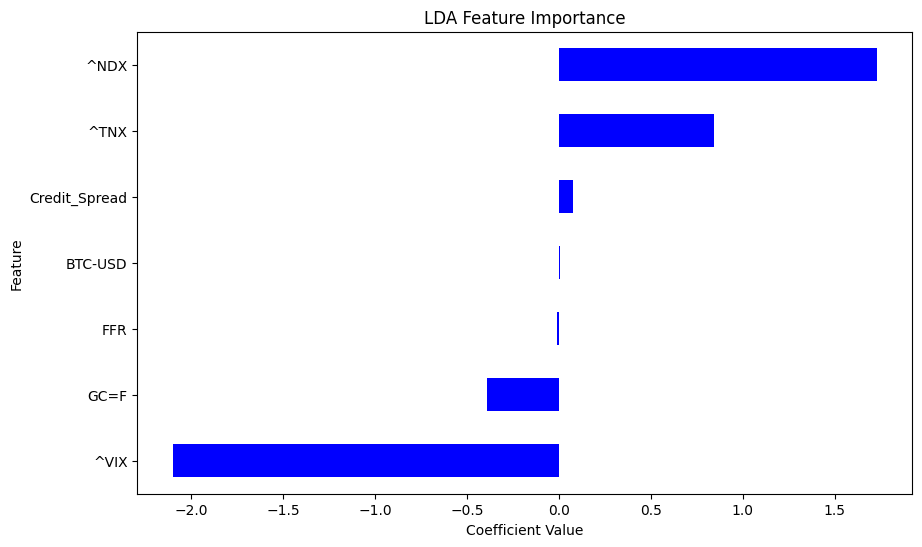

In [14]:
# 1. Feature Importance (LDA Coefficients)
coefficients = pd.Series(lda.coef_[0], index=X.columns)
coefficients = coefficients.sort_values()
plt.figure(figsize=(10, 6))
coefficients.plot(kind='barh', color="Blue")
plt.title('LDA Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

Significant Features:
* The features with the longest bars (either to the left or right) have the most significant influence on the LDA model's predictions.
In this case, '^VIX' and '^NDX' are the most influential, but they are influential in opposite directions.

Direction of Influence:
* Features with bars extending to the right have a positive correlation with the outcome being predicted (e.g. bullish market).
* Features with bars extending to the left have a negative correlation (e.g. bearish market).
* '^VIX' has a strong negative correlation, meaning as the VIX increases, the model is more likely to predict a bearish market.
* '^NDX' has a strong positive correlation, meaning as the NDX increases, the model is more likely to predict a bullish market.

Impact of Feature Shrinkage:
* Features with shorter bars have a weaker impact on the model's predictions. Features like 'FFR' and 'GC=F' have very little impact and have been reduced by the application of shrinkage='auto' has resulted in increased magnitudes for the coefficients of '^VIX' and '^NDX', indicating a strengthened influence of these features on the model's predictions. This suggests a more robust and stable model, where the key features play an even more significant role in determining market regime classifications.

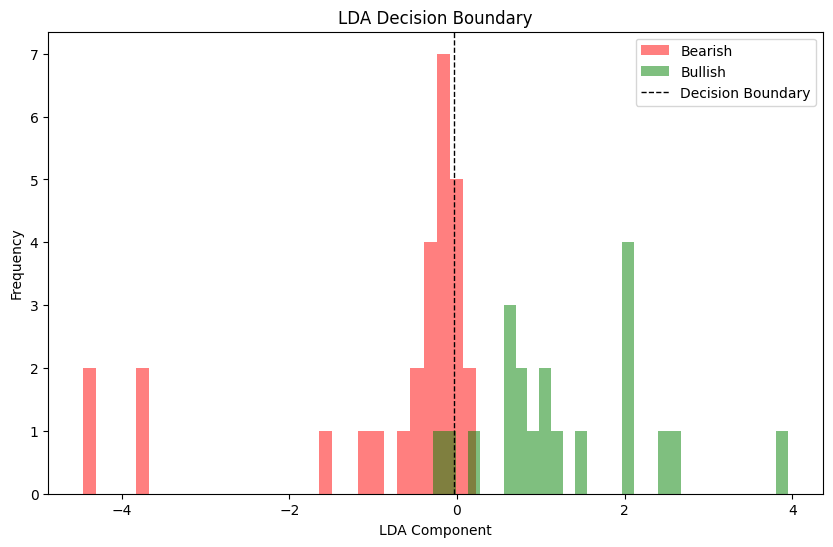

In [15]:
# 2. LDA Decision Boundary
X_lda = lda.transform(X_test)
plt.figure(figsize=(10, 6))
plt.hist(X_lda[y_test == 0], bins=30, alpha=0.5, label='Bearish', color="red")
plt.hist(X_lda[y_test == 1], bins=30, alpha=0.5, label='Bullish', color="green")
threshold = (np.max(X_lda[y_test == 0]) + np.min(X_lda[y_test == 1])) / 2
plt.axvline(x=threshold, color='black', linestyle='--', linewidth=1, label='Decision Boundary')

plt.title('LDA Decision Boundary')
plt.xlabel('LDA Component')
plt.ylabel('Frequency')
plt.legend()
plt.show()

LDA Component Interpretation: The components represents a linear combination of the original features that maximizes the separation between two classes.
* Lower values of the LDA component are more associated with bearish markets, and higher values are more associated with bullish markets.

Model Performance: The degree of overlap between the two histograms provides an indication of the model's performance.
* Less overlap indicates better separation and higher classification accuracy.
* The overlapping areas represent instances where the model may have difficulty distinguishing between the two regimes.
* The position of the decision boundary relative to the overlap suggests how well the model separates the two classes.

Data Distribution: The shape of the histograms reveals the distribution of the projected data for each class.
* The bearish histogram is skewed left with a peak around -2, while the bullish histogram is more normally distributed, peaking near 2 with a slight right skew. This distribution suggests that bearish regimes are more consistently projected to lower LDA values, while bullish regimes have a broader spread.
* The decision boundary’s alignment with the overlap region indicates a balanced model, but the slight overlap near the boundary may lead to higher misclassification rates for ambiguous cases, potentially warranting further model refinement.



In [16]:
# Fit PCA on the training data and transform both training and testing data
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)  # Fit PCA on training data
X_test_2d = pca.transform(X_test)  # Transform testing data using the same PCA

# Create a meshgrid in the 2D PCA space to compute the decision boundary
x_min, x_max = min(X_train_2d[:, 0].min(), X_test_2d[:, 0].min()) - 1, max(X_train_2d[:, 0].max(), X_test_2d[:, 0].max()) + 1
y_min, y_max = min(X_train_2d[:, 1].min(), X_test_2d[:, 1].min()) - 1, max(X_train_2d[:, 1].max(), X_test_2d[:, 1].max()) + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Inverse transform the meshgrid points back to the original feature space for LDA prediction
mesh_points = np.c_[xx.ravel(), yy.ravel()]
mesh_full = pca.inverse_transform(mesh_points)  # Inverse transform to original space
Z = lda.predict(mesh_full)  # Predict using the LDA model
Z = Z.reshape(xx.shape)

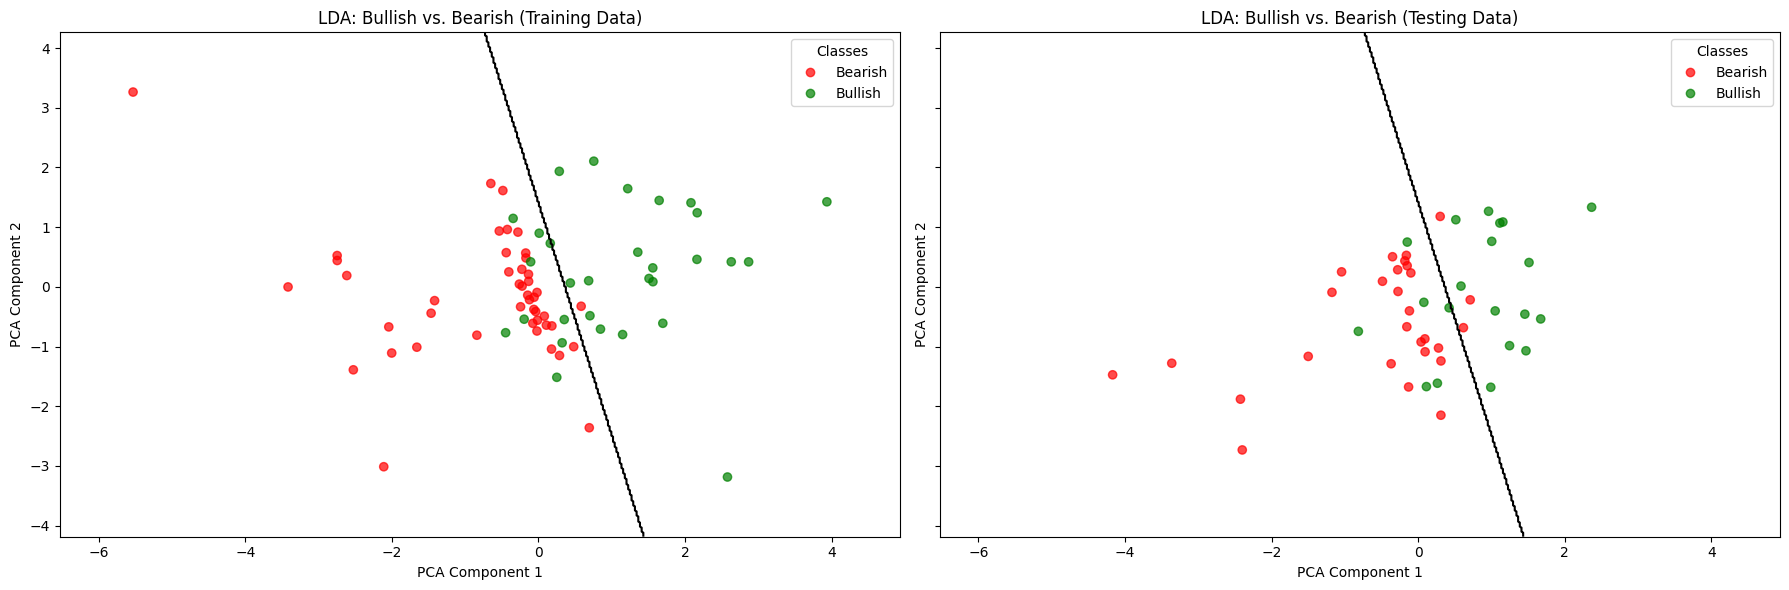

In [17]:
# Create side-by-side scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)

# Define a custom colormap: red for bearish (0), green for bullish (1)
custom_cmap = ListedColormap(['red', 'green'])

# 3. (a) LDA: Bullish vs. Bearish (Training Data)
scatter1 = ax1.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=custom_cmap, alpha=0.7)
ax1.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='-')  # Solid boundary line
ax1.set_title('LDA: Bullish vs. Bearish (Training Data)')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
handles1, _ = scatter1.legend_elements()
ax1.legend(handles1, ['Bearish', 'Bullish'], title="Classes", loc="upper right")

# 3. (b) LDA: Bullish vs. Bearish (Testing Data)
scatter2 = ax2.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=custom_cmap, alpha=0.7)
ax2.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='-')  # Solid boundary line
ax2.set_title('LDA: Bullish vs. Bearish (Testing Data)')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
handles2, _ = scatter2.legend_elements()
ax2.legend(handles2, ['Bearish', 'Bullish'], title="Classes", loc="upper right")

plt.tight_layout()
plt.show()

Data Projection and Visualization:
* These side-by-side scatter plots bring the training (left) and testing (right) data to life in a 2D PCA space, where bearish (red) and bullish (green) points are divided by the LDA decision boundary.
* PCA is used to distill the high-dimensional feature set into two components, preserving the data’s variance while making the LDA boundary visible in a 2D plot.

Training Data Performance:
* The LDA boundary cleanly separates bearish and bullish classes in the training data, with tight clustering and minimal overlap, indicating a robust fit to the training patterns.
* This strong separation builds confidence in the model’s ability to capture market regimes, though it hints at potential overfitting.

Testing Data Generalization:
* The same LDA boundary faces unseen data, and we see more scatter and overlap, with several bearish and bullish points landing on the wrong side.
* This misclassification points to potential overfitting: the model’s precision on the training data doesn’t fully translate to the test set.
* A wider spread in the test data also indicates a possible distribution shift, reflecting varying market dynamics.


Model Insight and Next Steps:
* The consistent boundary highlights the model’s generalization effort, but the reduced separation in testing data suggests overfitting,
* Adjustments like LDA shrinkage regularization or nonlinear models (such SVMs) can improve generalization to new market conditions.

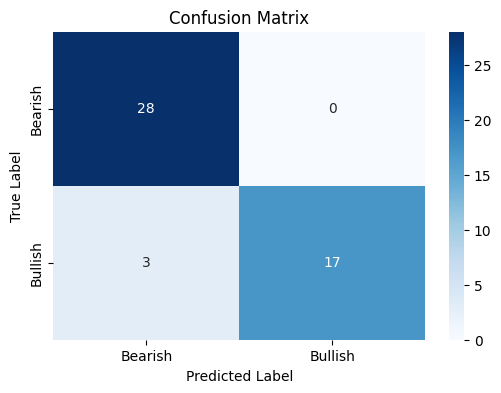

In [18]:
# 4. Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bearish', 'Bullish'], yticklabels=['Bearish', 'Bullish'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

* The confusion matrix shows 28 true negatives (correctly predicted bearish), 17 true positives (correctly predicted bullish), 3 false negatives (predicted bearish, but actually bullish), and 0 false positives (predicted bullish, but actually bearish).

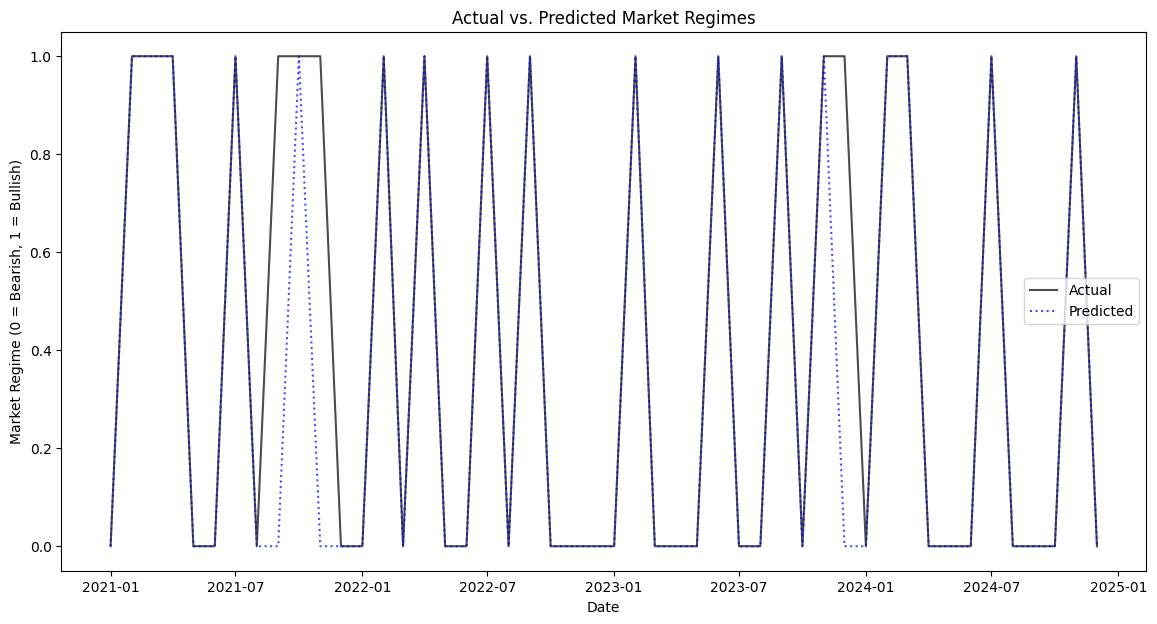

In [19]:
# 5. Actual vs. Predicted Market Regimes
plt.figure(figsize=(14, 7))

# Filter data index to match y_test and y_pred
filtered_index = data.index[data.index >= split_date]

# Trim filtered_index to match the length of y_test and y_pred, taking the minimum length to ensure alignment
min_length = min(len(y_test), len(y_pred))
filtered_index = filtered_index[:min_length]

# Slice y_test and y_pred to match the length of filtered_index
y_test_trimmed = y_test[:min_length]
y_pred_trimmed = y_pred[:min_length]

plt.plot(filtered_index, y_test_trimmed, label='Actual', alpha=0.7, color="black", linestyle='-')
plt.plot(filtered_index, y_pred_trimmed, label='Predicted', alpha=0.7, color="blue", linestyle=':')
plt.title('Actual vs. Predicted Market Regimes')
plt.xlabel('Date')
plt.ylabel('Market Regime (0 = Bearish, 1 = Bullish)')
plt.legend()
plt.show()

Timing of Predictions: The plot reveals the timing of prediction errors. It shows when the model incorrectly predicted a bullish or bearish regime.
* It's possible to see the instances where the model predicted a change in regime earlier or later than when it actually occurred.

Trend Following: The plot indicates whether the model is better at identifying certain market trends (e.g., long bullish periods or sudden bearish shifts).
* By visual inspection, the model has a decent capability of detecting changes, but it is not perfect.

Model Evaluation:
* This plot is a valuable tool for evaluating the model's performance over time and identifying areas where it may need improvement.
* It provides a more intuitive understanding of the model's accuracy compared to a simple confusion matrix, as it shows the temporal aspect of the predictions.

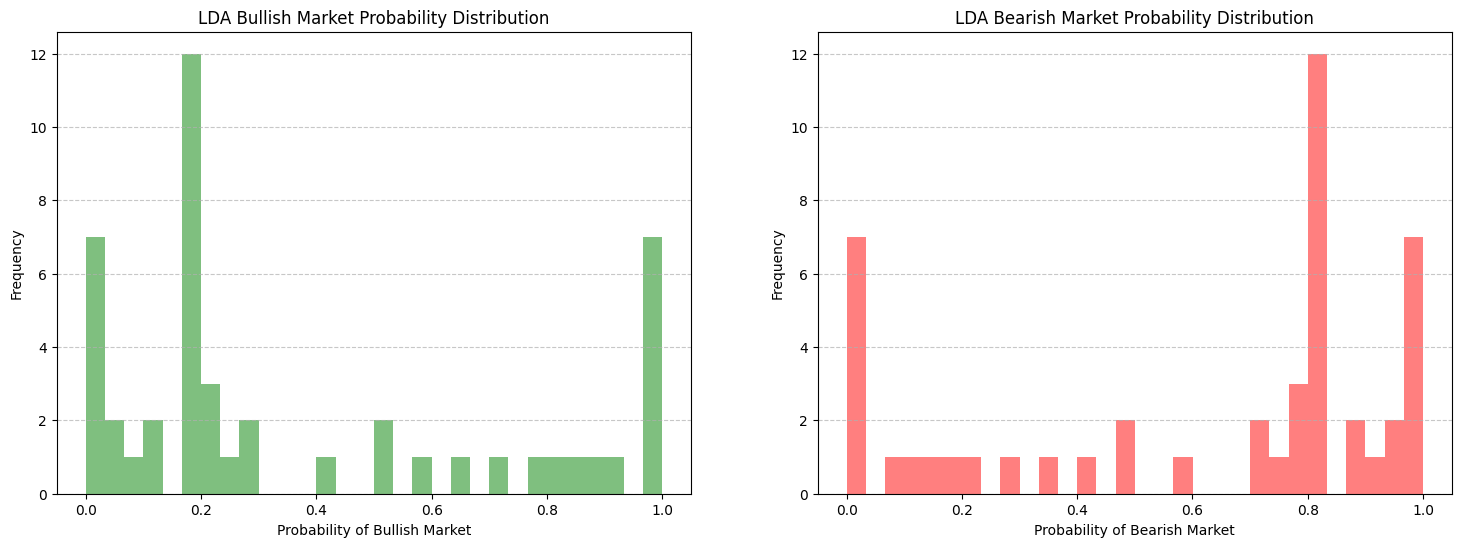

In [20]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# 6. (a) LDA Bullish Market Probability Distribution
axes[0].hist(lda.predict_proba(X_test)[:, 1], bins=30, alpha=0.5, color='green')
axes[0].set_title('LDA Bullish Market Probability Distribution')
axes[0].set_xlabel('Probability of Bullish Market')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 6. (b) LDA Bearish Market Probability Distribution
axes[1].hist(lda.predict_proba(X_test)[:, 0], bins=30, alpha=0.5, color='red')
axes[1].set_title('LDA Bearish Market Probability Distribution')
axes[1].set_xlabel('Probability of Bearish Market')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Prediction Bias:
* The red histogram (bearish) shows a skew towards higher probabilities (closer to 1), indicating the model frequently predicts bearish markets with high confidence.
* Conversely, the green histogram (bullish) is skewed towards lower probabilities (closer to 0), suggesting the model is less confident in predicting bullish markets.

Asymmetrical Prediction:
* The noticeable difference in skew between the two histograms reveals an asymmetry in the model's predictive behavior. It is more inclined to strongly predict bearish markets than bullish ones.

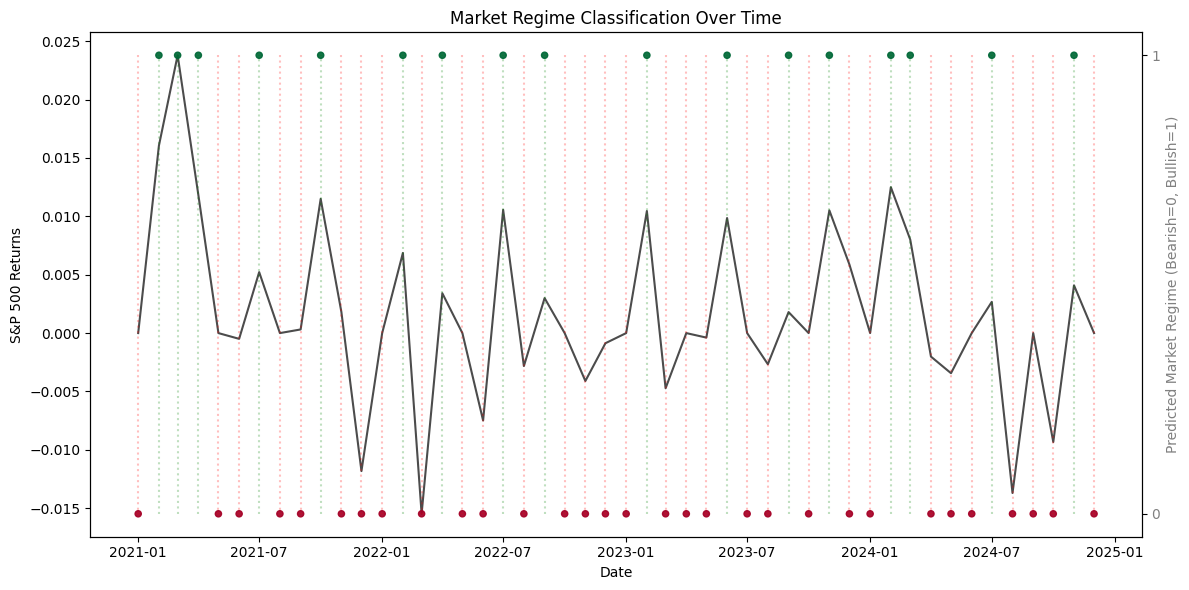

In [21]:
# 7. Market Regime Classification Over Time
plt.figure(figsize=(12, 6))

# Filter returns to match the date range of data AND the split date
filtered_returns = returns.loc[data.index]
filtered_returns_after_split = filtered_returns[filtered_returns.index >= split_date]

y_pred_filtered = pd.Series(y_pred, index=filtered_returns_after_split.index[:len(y_pred)])

# Trim filtered_returns_after_split to match the length of y_pred_filtered
filtered_returns_after_split = filtered_returns_after_split.iloc[:len(y_pred_filtered)]

# Create the first y-axis for S&P 500 Returns (only after split_date)
ax1 = plt.gca() # Get current axes
ax1.plot(filtered_returns_after_split.index, filtered_returns_after_split['^GSPC'], color='black', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Returns', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for Predicted Market Regime
ax2 = ax1.twinx()
for date, prediction in y_pred_filtered.items():
    ax2.plot([date, date], [0, prediction], color='green', alpha=0.25, linestyle=':')
    ax2.plot([date, date], [1, prediction], color='red', alpha=0.25, linestyle=':')
ax2.scatter(filtered_returns_after_split.index, y_pred_filtered, c=y_pred_filtered, cmap='RdYlGn', s=20, alpha=0.925) # added alpha

ax2.set_ylabel('Predicted Market Regime (Bearish=0, Bullish=1)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.set_yticks([0, 1]) # Ensure y-ticks are only at 0 and 1

# Add title and legend
plt.title('Market Regime Classification Over Time')
# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2

# Improve layout
plt.tight_layout() # Adjust layout to prevent overlapping elements
plt.show()

Regime Prediction vs. Returns:
* The plot allows for a direct comparison of the model's predicted market regimes with the actual market performance (S&P 500 returns).
* The model's predictions seem to align reasonably well with the S&P 500 returns with periods where the predicted bullish/bearish regimes indeed correspond to upward/downward trends in the returns.

Model Performance Over Time:
* The plot provides a temporal view of the model's accuracy, revealing how well it performs during different market conditions.

# Category 6: Support Vector Machines.

To illustrate the Support Vector Machine Algorithm, we will consider loan prediction dataset sourced from Kaggle. The dataset contained 13 different loan attributes ranging from the borrower's gender, marital status, educational background, loan ID, loan amount, credit history etc.

- For the dataset, we will implement different approaches:
- Approach 1: Apply SVM classifier to split data using Laon status as the target class.Additionaly, we'll determine the optimal tuning yperparameters to use in the classification problem.
- Approach 2: Apply SVM Regreessor to model the data comparing Predicted Loan Amount with Actual Loan Amount. Additionally, we will also compare the regressor model's performance with that of other regression models.

## Load Packages

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report,  mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay

In [23]:
from google.colab import files
uploaded = files.upload()


Saving loan_predictor.csv to loan_predictor.csv


In [24]:
# load the dataset
import pandas as pd
data_df = pd.read_csv("loan_predictor.csv")
data_df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Exploratory Data Analysis

In [25]:
data_df.shape

(614, 13)

In [26]:
data_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [27]:
# drop null values.
data_df.isnull().sum()
data_df.dropna()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


## Data Preprocessing

**Label Encoding**

In [28]:
# Define mapping dictionary for laan_Status
label_mapping = {'Y': 1, 'N': 0}

# Apply label encoding to dataframe
data_df['Loan_Status'] = data_df['Loan_Status'].map(label_mapping)
data_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


- Highlight relevant variables in the dataset Married, Dependents, Education, Self_Employed, Credit_History, Property_Area, Loan Amount, Loan Status etc.

- Replacing inconsistent values and drop or fill NaN values.

In [29]:
# replacing the Dependents 3+ values with 4
data_df = data_df.replace(to_replace='3+', value=4)
data_df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,1
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,1
7,LP001014,Male,Yes,4,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,0
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,1
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,0


In [30]:
# replacing the Credit_History NaN values with 0
data_df = data_df.replace(to_replace='NaN', value=0)
data_df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,1
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,1
7,LP001014,Male,Yes,4,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,0
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,1
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,0


## Approach 1: Model Training & Evaluation using SVM Classifier

- Now we will classify the other variables in the data based on the Loan Status (where value 1 - indicates that applicant is eligible for loan, 0: indicates applicant is NOT eligible for a loan).

- We will also visualise different categories in each variable (attributes) on seaborn plot using Loan status as basis

### Visualise Features

Married
Yes    398
No     213
Name: count, dtype: int64
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64
Dependents
0    345
1    102
2    101
4     51
Name: count, dtype: int64
Self_Employed
No     500
Yes     82
Name: count, dtype: int64
Credit_History
1.0    475
0.0     89
Name: count, dtype: int64
Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64


Text(0.5, 1.0, 'Property Area')

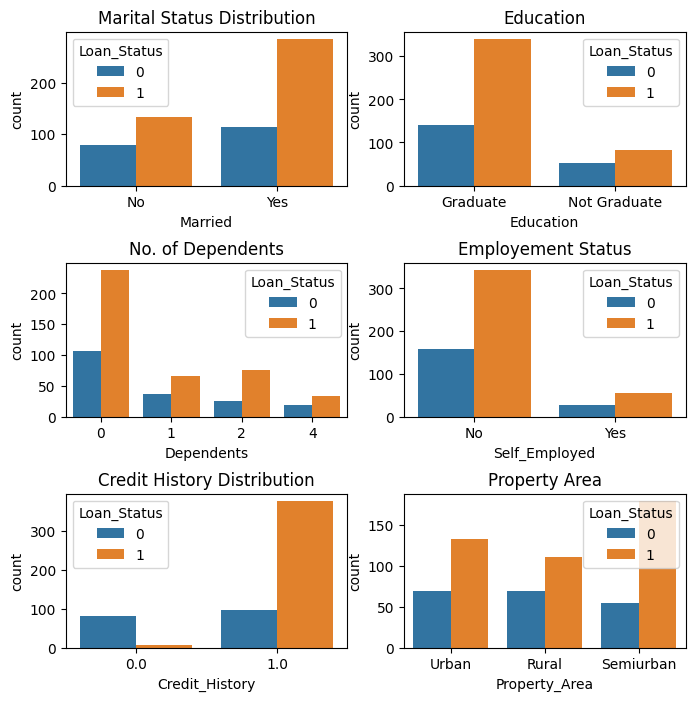

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8))  # 2 rows, 2 columns
plt.subplots_adjust(hspace=0.5)

# Plot different distributions
print(data_df["Married"].value_counts())
sns.countplot(x='Married',hue='Loan_Status',data=data_df, ax=axes[0,0])
axes[0, 0].set_title("Marital Status Distribution")

print(data_df["Education"].value_counts())
sns.countplot(x='Education',hue='Loan_Status',data=data_df, ax=axes[0,1])
axes[0, 1].set_title("Education")

print(data_df["Dependents"].value_counts())
sns.countplot(x='Dependents',hue='Loan_Status',data=data_df, ax=axes[1,0])
axes[1, 0].set_title("No. of Dependents")

print(data_df["Self_Employed"].value_counts())
sns.countplot(x='Self_Employed',hue='Loan_Status',data=data_df, ax=axes[1,1])
axes[1, 1].set_title("Employement Status")


print(data_df["Credit_History"].value_counts())
sns.countplot(x='Credit_History',hue='Loan_Status',data=data_df, ax=axes[2,0])
axes[2, 0].set_title("Credit History Distribution")

print(data_df["Property_Area"].value_counts())
sns.countplot(x="Property_Area",hue='Loan_Status',data=data_df, ax=axes[2,1])
axes[2, 1].set_title("Property Area")

In [32]:
# convert categorical columns to numerical values
data_df.replace({'Married':{'No':0,'Yes':1},'Gender':{'Male':1,'Female':0},'Self_Employed':{'No':0,'Yes':1},
                      'Property_Area':{'Rural':0,'Semiurban':1,'Urban':2},'Education':{'Graduate':1,'Not Graduate':0}},inplace=True)

<ipython-input-32-ed85bb297597>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_df.replace({'Married':{'No':0,'Yes':1},'Gender':{'Male':1,'Female':0},'Self_Employed':{'No':0,'Yes':1},


Proceed to drop more NaN values, as NaN values affect selection of optimal  **hyperparamters**

In [33]:
data_df.dropna()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,1.0,1.0,1,1,0.0,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1.0,1.0,0,1,1.0,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1.0,1.0,0,0,0.0,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1.0,0.0,0,1,0.0,6000,0.0,141.0,360.0,1.0,2,1
5,LP001011,1.0,1.0,2,1,1.0,5417,4196.0,267.0,360.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0.0,0.0,0,1,0.0,2900,0.0,71.0,360.0,1.0,0,1
610,LP002979,1.0,1.0,4,1,0.0,4106,0.0,40.0,180.0,1.0,0,1
611,LP002983,1.0,1.0,1,1,0.0,8072,240.0,253.0,360.0,1.0,2,1
612,LP002984,1.0,1.0,2,1,0.0,7583,0.0,187.0,360.0,1.0,2,1


Inspect for features with more NaN values. We proceed to remove features with NaN values for optimal hyperparamters selection

In [34]:
data_df.isnull().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


**Specify X and y(target) variables**

For the classification task, we will classify the data by its Loan Status

In [35]:
# separating the data and label.
X = data_df.drop(columns=['Loan_ID','Loan_Status', "Gender", "Married", "Dependents", "Self_Employed", "LoanAmount", "Loan_Amount_Term", "Credit_History"],axis=1) # Loan_ID is irrelavent in our case
X.dropna()
y = data_df['Loan_Status']
y.dropna()

,Loan_Status
0,1
1,0
2,1
3,1
4,1
...,...
609,1
610,1
611,1
612,1


In [36]:
# print X an y values
print(X)
print(y)

     Education  ApplicantIncome  CoapplicantIncome  Property_Area
0            1             5849                0.0              2
1            1             4583             1508.0              0
2            1             3000                0.0              2
3            0             2583             2358.0              2
4            1             6000                0.0              2
..         ...              ...                ...            ...
609          1             2900                0.0              0
610          1             4106                0.0              0
611          1             8072              240.0              2
612          1             7583                0.0              2
613          1             4583                0.0              1

[614 rows x 4 columns]
0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64


In [37]:
# from sklearn.cross_validation import train_test_split (training_size = 80, test_size=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Determine the Best Hyperparameters**

To determine the best kernel and slack variable value, we do a grid search method using `GridSearchCV`. This will explore the specified hyperparameter space for the optimal values over five cross validations.

In [38]:
# defining parameter range
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    #               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["rbf", "linear", "poly"],
}

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3, cv=5)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.697 total time=   0.0s
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.694 total time=   0.0s
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.694 total time=   0.0s
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.704 total time=   0.0s
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.697 total time=  23.8s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.694 total time=  25.1s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.694 total time=  28.7s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.694 total time=  44.7s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.704 total time=  27.9s
[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/5] END ...............C=0.01, kernel=poly;

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=3)

In [39]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 0.01, 'kernel': 'poly'}
SVC(C=0.01, kernel='poly')


From the results above, we can deduce that regularization parameter C = 0.01 & the **polynomial** kernel function are the best suitable parameters for tuning the model

### Train the SVM Classifier

Here, we proceed to fit the SVM classifier with the best hyperparameters selected. In simple terms, we train data with tuned SVM. Additonally, we'll also consider fitting Decision tree classification to the same training set to compare accuracy of the SVM Classification Model

In [40]:
# Train with Tuned SVM
# Create a svm Classifier
clf_tuned = svm.SVC(
    random_state=42,
    C=grid.best_params_["C"],
    kernel=grid.best_params_["kernel"],
    probability=True,
)

clf_tuned.fit(X_train, y_train) # fit tuned SVM to training set


# Fitting Decision Tree Classification to the Training set as well

clf_tree = DecisionTreeClassifier(
    criterion="entropy",
    random_state=42,
    max_depth=8,
    min_samples_leaf=30,  # DM
    min_samples_split=20,
    #                               , class_weight=classweight
)  # DM
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=30,
                       min_samples_split=20, random_state=42)

### Evaluate SVM Classifier Performance

**ROC Curve**

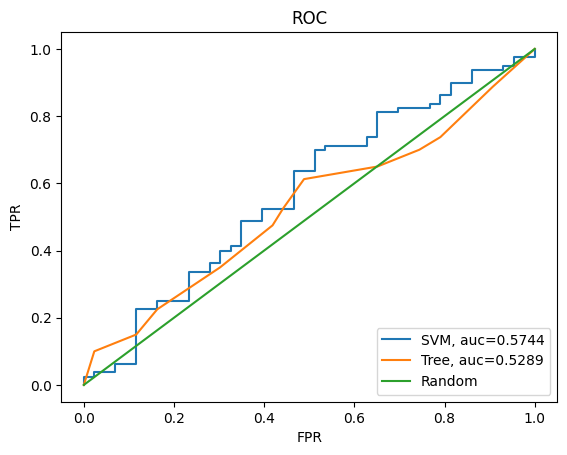

In [41]:
# Performance

# predicted probabilities generated by sklearn classifier
y_pred_proba = clf_tuned.predict_proba(X_test)
y_pred_probatree = clf_tree.predict_proba(X_test)

# SVM ROC dependencies
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
# TREE ROC dependencies
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_probatree[:, 1])

auc = round(roc_auc_score(y_test, y_pred_proba[:, 1]), 4)
auc_tree = round(roc_auc_score(y_test, y_pred_probatree[:, 1]), 4)

# SVM Model
plt.plot(fpr, tpr, label="SVM, auc=" + str(auc))
# Tree model
plt.plot(fpr_tree, tpr_tree, label="Tree, auc=" + str(auc_tree))
# Random guess model
plt.plot(fpr, fpr, "-", label="Random")
plt.title("ROC")
plt.ylabel("TPR")
plt.xlabel("FPR")

plt.legend(loc=4)
plt.show()

On evaluating the performance of the SVM classifier on the basis of area under curve in a ROC curve, we notice that SVM performs better than a random guess and is not very far from the decision tree classifier.

**Performance on Test Set**

In [42]:
best_svm_model = grid.best_estimator_

In [43]:
# accuracy score on the test data
y_pred = best_svm_model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy score of the test data : ', accuracy)

Accuracy score of the test data :  0.6504065040650406


In [44]:
# Classificaion Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.65      1.00      0.79        80

    accuracy                           0.65       123
   macro avg       0.33      0.50      0.39       123
weighted avg       0.42      0.65      0.51       123



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


65% accuracy score s obtained for the SVM classifier.

## Approach 2: Model Training & Evaluation using SVM Regressor

### Load Packages

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error




### Data Preprocessing

In [46]:
# Load the dataset
data_df = pd.read_csv("loan_predictor.csv")

# Drop irrelevant columns
data_df.drop(columns=['Loan_ID'], inplace=True)

# Fill missing values
data_df.fillna(data_df.median(numeric_only=True), inplace=True)
data_df.fillna(data_df.mode().iloc[0], inplace=True)

# Encode categorical variables
label_encoders = {}
for col in data_df.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()
    data_df[col] = label_encoders[col].fit_transform(data_df[col])



**Specify Features and Target**

The LoanAmount is selected as target variable (y) while other variables are specified as features (X)

In [47]:
# Define features and target
X = data_df.drop(columns=["LoanAmount"])  # Predicting Loan Amount
y = data_df["LoanAmount"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Standardise Data

We apply StandardScaler() to normalise data before running the SVM regressor model

In [48]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Run the SVM Regressor Model

We make use of the **radial basis function (rbf)** kernel function and explore hyperparameters C, gamma and epsilon to determine the most suitable for the regression tasks (using GridSearchCV cross validator). We proceed to train data with the tuned regressor and evaluate the performance of the model using Mean-Squared-Error.

In [49]:

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], #regularization parameter (determines level of fit)
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1], #gamma: checks the level of training influence
    'epsilon': [0.0001, 0.001, 0.01, 0.1, 1] #epsilon: measures margin tolerance
}

# Perform Grid Search
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train best model
best_svr = SVR(kernel='rbf', **best_params)
best_svr.fit(X_train, y_train)

# Predict and Evaluate
y_pred_tuned = best_svr.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
print(f"Tuned Mean Squared Error: {mse_tuned:.2f}")


Best Parameters: {'C': 100, 'epsilon': 0.0001, 'gamma': 0.01}
Tuned Mean Squared Error: 2572.07


We will proceed to extract the supporting vectors indices as we intend to visualise tese vectors in the regression plot

In [50]:
# Extract support vector indices
support_vectors_indices = best_svr.support_
support_vectors = X_train[support_vectors_indices]
support_values = y_train.iloc[support_vectors_indices]

print(f"Number of support vectors: {len(support_vectors)}")


Number of support vectors: 491


### Visualise SVM Regressor Plot

The SVR (i.e SVM Regressor plot) is a plot of predicted target variable vs actual target variable with perfect prediction regression line (optimal hyperplane) and optional supporting vectors to show the margin tolerance between the training data points on both sides of the regressor line.

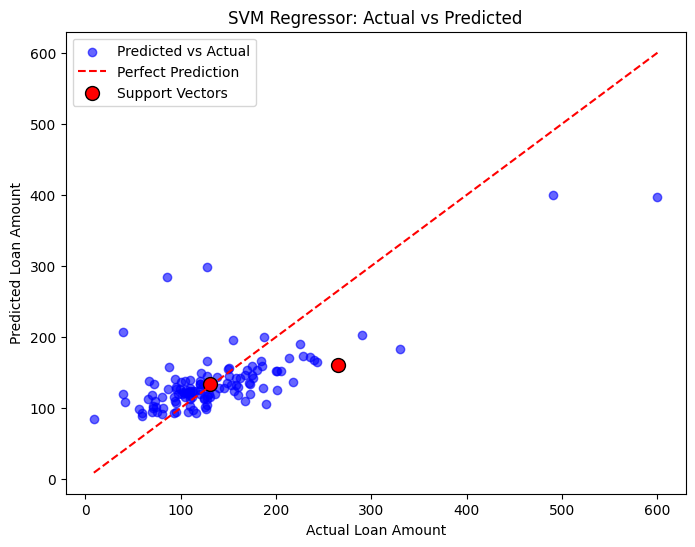

In [51]:

# Plot predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tuned, color='blue', alpha=0.6, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--", label="Perfect Prediction") #hyperplane
plt.scatter(support_values[:2], best_svr.predict(support_vectors[:2]), color='red', edgecolors='black', s=100, label="Support Vectors")
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.title("SVM Regressor: Actual vs Predicted")
plt.legend()
plt.show()


### Compare SVM Regressor Performance with other Regression Models

Here, we will use the Mean Squared Error as a basis to compare the performance of SVM Regressor and other Regression Models such as RandomForest and XGBoost Regression.

**RandomForest Regressor Model**

In [52]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.2f}")


Random Forest MSE: 3634.35


**XGBRegressor Model**

In [53]:
from xgboost import XGBRegressor

# Initialize and train XGBoost model
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb:.2f}")


XGBoost MSE: 3428.84


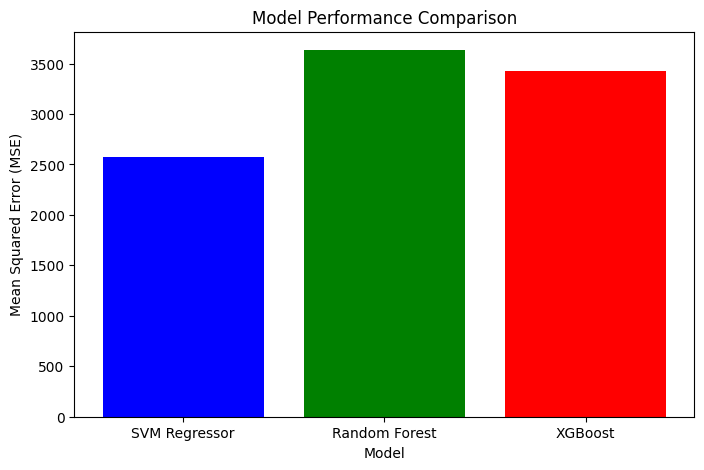

In [54]:
models = ["SVM Regressor", "Random Forest", "XGBoost"]
mse_scores = [mse_tuned, mse_rf, mse_xgb]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_scores, color=['blue', 'green', 'red'])
plt.xlabel("Model")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Model Performance Comparison")
plt.show()


Upon comparison of all three models, we notice that SVM Regressor had the least MSE value, hence suited for modelling the data

# Category 7: Neural Networks.

Computation

installing fredapi

In [55]:
!pip install fredapi

fetching data

In [56]:
# Initialize FRED API with your key
fred = Fred(api_key='3085603a10d918d77f7a6789fd1a57ef')

# Function to fetch data from FRED
def fetch_fred_data(series, start_date, end_date):
    data = {}
    for item in series:
        data[item] = fred.get_series(item, observation_start=start_date, observation_end=end_date)
    return pd.DataFrame(data)

# Specify FRED series and fetch data
fred_series = ['FEDFUNDS', 'BAA', 'AAA']  # Use actual FRED codes here
macro_data = fetch_fred_data(fred_series, start_date='2017-11-01', end_date='2025-01-01')
macro_data.dropna(inplace=True)

daily returns

In [57]:
import yfinance as yf

tickers = ['^GSPC', '^NDX', '^VIX', '^TNX', 'GC=F', 'BTC-USD', 'ETH-USD']
market_data = yf.download(tickers, start="2017-11-01", end="2025-01-01")['Close']
market_data.dropna(inplace=True)

# Now calculate returns
returns = market_data.pct_change().dropna()


[*********************100%***********************]  7 of 7 completed


In [58]:
# Calculating Credit Spread (Baa - Aaa yield)
macro_data['Credit_Spread'] = macro_data['BAA'] - macro_data['AAA']
macro_data.dropna(inplace=True)


In [59]:
# Merging market returns with macroeconomic data
data = returns.merge(macro_data[['FEDFUNDS', 'Credit_Spread']], left_index=True, right_index=True, how='inner')
data.dropna(inplace=True)

In [60]:
# Defining binary target: 1 if ^GSPC returns positive, else 0
data['Target'] = (data['^GSPC'] > 0).astype(int)

# Separate features and target
X = data.drop(columns=['Target', '^GSPC'])
y = data['Target']


In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [63]:
#training data
from sklearn.neural_network import MLPClassifier

# Neural network model initialization
model = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', solver='adam', max_iter=300, random_state=1)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(16, 8), max_iter=300, random_state=1)

In [64]:
#results
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[4 1]
 [2 5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.83      0.71      0.77         7

    accuracy                           0.75        12
   macro avg       0.75      0.76      0.75        12
weighted avg       0.76      0.75      0.75        12


Accuracy Score: 0.75


Illustrations

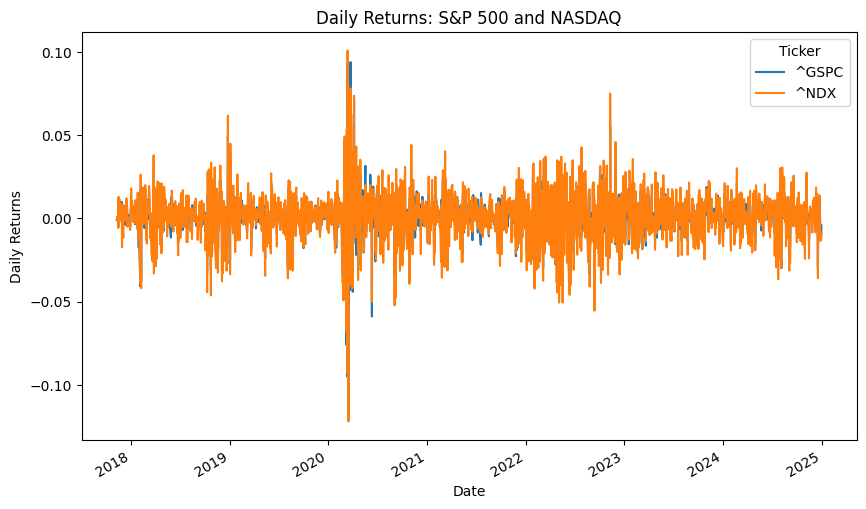

In [65]:
# Visualization 1: Daily Returns
returns[['^GSPC', '^NDX']].plot(figsize=(10, 6))
plt.title('Daily Returns: S&P 500 and NASDAQ')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.show()

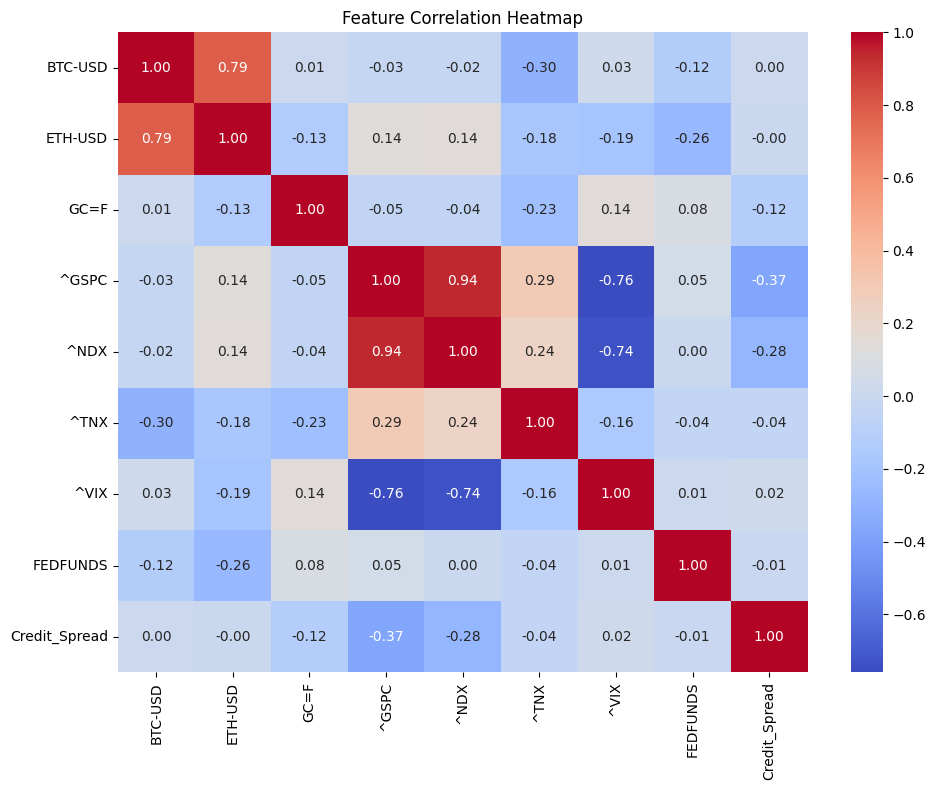

In [66]:
import matplotlib.pyplot as plt

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(data.drop(columns='Target').corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

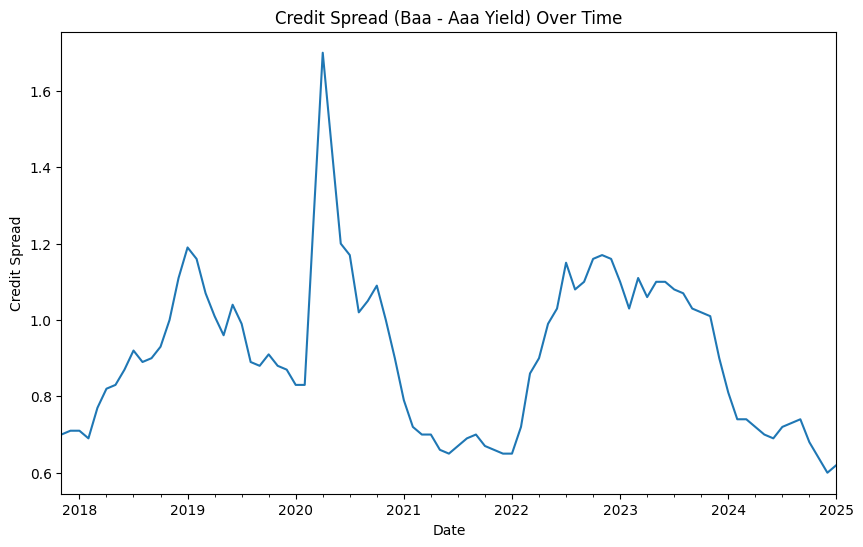

In [67]:
# Visualization 4: Credit Spread over time
macro_data['Credit_Spread'].plot(figsize=(10, 6))
plt.title('Credit Spread (Baa - Aaa Yield) Over Time')
plt.xlabel('Date')
plt.ylabel('Credit Spread')
plt.show()

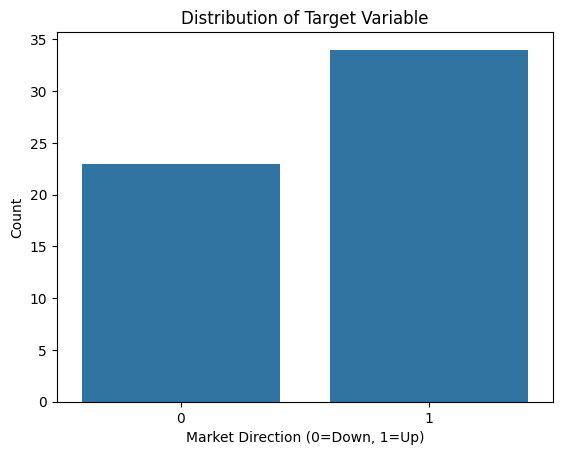

In [68]:
# Visualization 5: Target Variable Distribution
sns.countplot(x='Target', data=data)
plt.title('Distribution of Target Variable')
plt.xlabel('Market Direction (0=Down, 1=Up)')
plt.ylabel('Count')
plt.show()

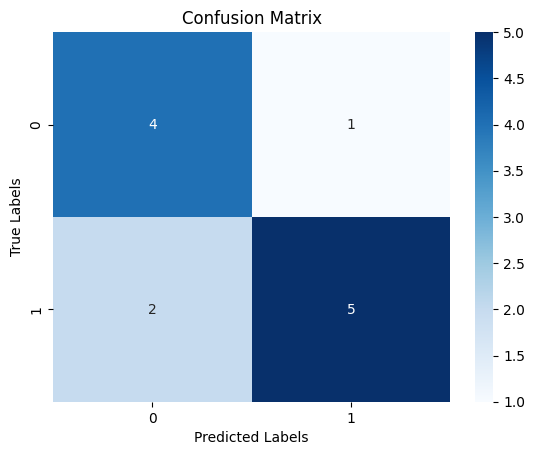

In [69]:
# Visualization 6: Neural Network Performance (Confusion Matrix)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# SAVE TO PDF

In [ ]:
from google.colab import files
import subprocess

# Upload the notebook file
uploaded = files.upload()

# Specify the notebook name (from the uploaded file)
notebook_name = list(uploaded.keys())[0]
html_name = notebook_name.replace('.ipynb', '.html')

# Convert the notebook to HTML
subprocess.run(["jupyter", "nbconvert", "--to", "html", notebook_name])

# Verify the HTML file is created
!ls /content

# Download the HTML file
files.download(html_name)

